In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import scipy.io as sio
from numpy.linalg import inv
import random
from numpy import linalg as LA
from numpy.linalg import matrix_rank
from scipy.optimize import minimize
from scipy import signal
from IPython.display import Audio, display
def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [2]:
A = sio.loadmat('Adj.mat')["A"]
#campo = sio.loadmat('Campo.mat')['a']
sampled = sio.loadmat('sampled_field.mat')["sampled_field"]
loc = sio.loadmat('xy.mat')["xy"]
x = list(sampled[:,0])

In [3]:
N = len(A)
A_cor = np.zeros((N, N))
D = np.zeros((N, N))  # Degree matrix
for i in range(N):
    for j in range(N):
        if i >j:
            if A[i,j] >0:
                A_cor[i,j] = 1
                A_cor[j,i] = 1
                
for i in range(N):
    D[i, i] = np.sum(A_cor[i, :])

L = D - A_cor  # Laplacian matrix
e_val,e_vec = np.linalg.eig(L)# Eigenvalues and eigenvectors
e_vec = np.transpose(e_vec)
idx = e_val.argsort() #indexes for sorting with respect to eigenvalues
e_val = e_val[idx]
e_vec = e_vec[idx]
e_sec = e_vec[1] #second eigenvector
U = np.transpose(np.asmatrix(e_vec))
R = np.diag(np.ones(N))

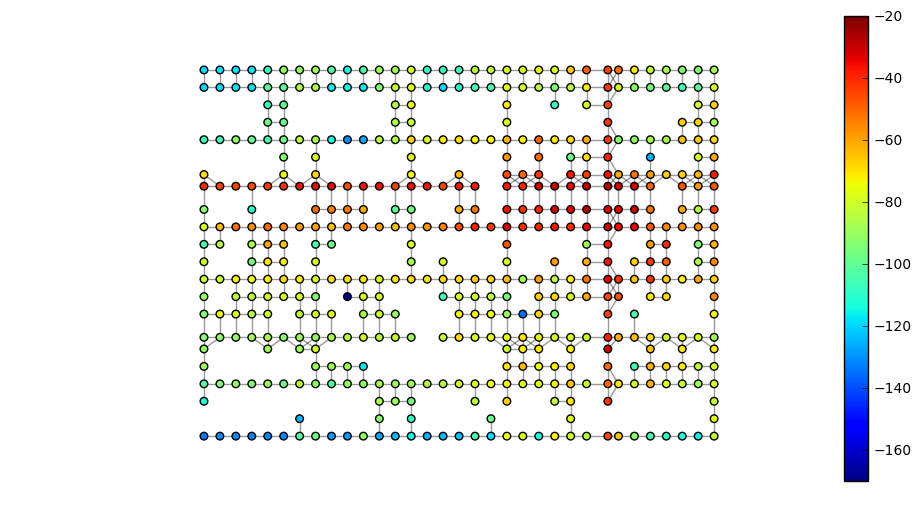

In [112]:
G = nx.from_numpy_matrix(A_cor, create_using=None)
plt.figure(figsize=(12,6))
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=np.asarray(x), with_labels=True,
                            node_shape='o', node_size=30, cmap=plt.cm.jet, vmin= -170,vmax = -20)
plt.colorbar(nc)
plt.axis('off')
plt.savefig("Graph.png", format="PNG")
plt.show()

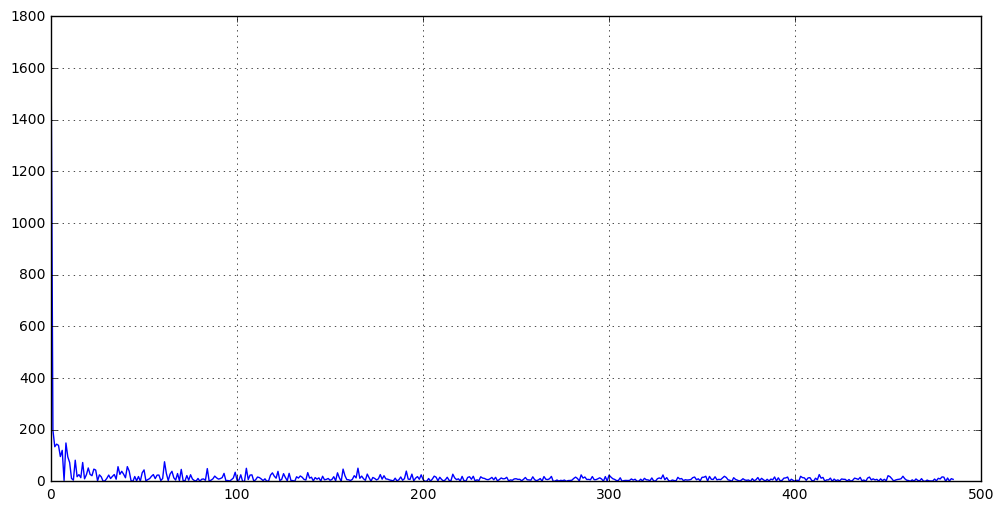

In [5]:
from scipy.fftpack import fft
plt.figure(figsize=(12,6))
yf = np.transpose(U).dot(x)
plt.plot(np.asarray(np.abs(yf))[0,:])
#plt.ylim(0,200)
plt.grid()
plt.show()


In [6]:
def f_sample(num,yf = yf):
    fs = np.asarray(np.abs(yf))[0,:]
    idx = fs.argsort() #indexes for sorting with respect to eigenvalues
    fs = fs[idx]
    ar = idx[-num:]
    return(ar[::-1])

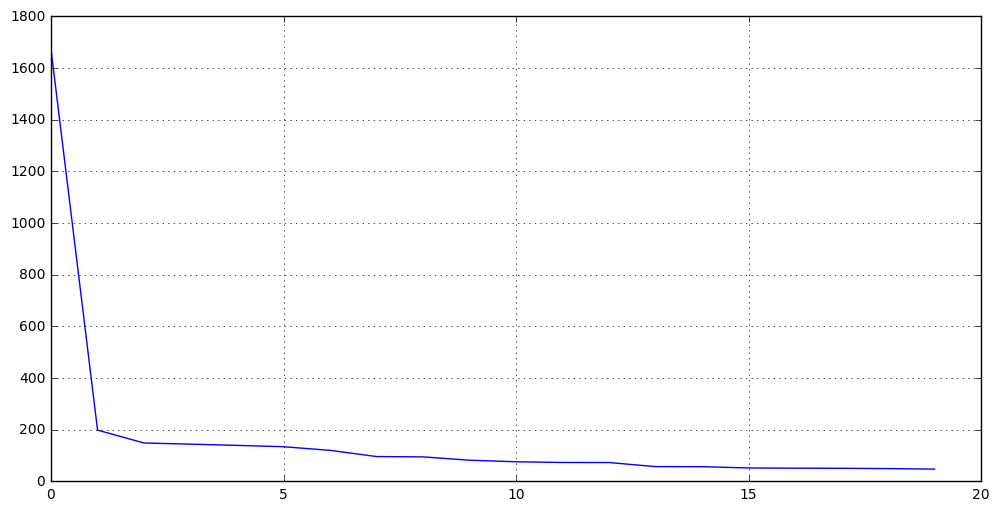

In [7]:
plt.figure(figsize=(12,6))
yf_f = np.asarray(np.abs(yf))[0,:][f_sample(20)]
plt.plot(yf_f)
#plt.ylim(0,200)
plt.grid()
plt.show()

In [8]:
def a_opt(s,U_f,R,R_inv):
    N = len(U)
    D_s = np.zeros((N,N))
    col = 0
    for i in s:
        D_s[i,i] = 1
        col = col+1    
    matrix = np.linalg.pinv(np.asmatrix(U_f).getH().dot(D_s).dot(R_inv).dot(U_f))
    res = np.trace(matrix)
    return(res)


In [9]:
def d_opt(s,U_f,R,R_inv):
    N = len(U)
    D_s = np.zeros((N,N))
    P_s = np.zeros((N,len(s)))
    col = 0
    for i in s:
        D_s[i,i] = 1
        P_s[i,col] = 1
        col = col+1
    matrix = np.asmatrix(U_f).getH().dot(D_s).dot(R_inv).dot(U_f)
    eig_values,_ = np.linalg.eig(matrix)
    pseudo_determinent = np.product(eig_values[eig_values > 1e-12])
    res = np.log(pseudo_determinent)
    return(res)

In [67]:
def e_opt(s,U_f):
    N = len(U)
    D_s = np.zeros((N,N))
    P_s = np.zeros((N,len(s)))
    col = 0
    for i in s:
        D_s[i,i] = 1
        P_s[i,col] = 1
        col = col+1
    D_sc = np.eye(N,N)-D_s
    _1, s, _2 = np.linalg.svd(D_sc.dot(U_f), full_matrices=True)
    
    return(np.max(s))

In [11]:
def reconstruct(f,s,U,R,x):
    N = len(U)
    D_s = np.zeros((N,N))
    U_f = np.zeros((N,len(f)))
    P_s = np.zeros((N,len(s)))
    col = 0
    for i in s:
        D_s[i,i] = 1
        P_s[i,col] = 1
        col = col+1
    col = 0
    for j in  f:
        U_f[:,col] = list(np.asarray(U)[:,j])
        col = col+1
    y_s = np.transpose(P_s).dot(x)
    matrix1 = inv(np.asmatrix(U_f).getH().dot(D_s).dot(U_f))
    x_hat = U_f.dot(matrix1).dot(np.asmatrix(U_f).getH()).dot(P_s).dot(y_s)
    return(np.asarray(x_hat)[0,:])

In [12]:
def nmse(f,s,U,R,x):
    x_hat = reconstruct(f,s,U,R,x)
    return(10*np.log10(LA.norm(x_hat-x,ord = 2)/LA.norm(x,ord = 2)))

In [68]:
def greedy(U,M,f,R,opt):
    S = []
    N = len(U)
    to_check = np.arange(N)
    R_inv = inv(R)
    U_f = np.zeros((N,len(f)))
    col = 0
    for j in  f:
        U_f[:,col] = list(np.asarray(U)[:,j])
        col = col+1
    while len(S)<M:
        res = [] 
        for j in to_check:
            cols = S + [j]
            if opt == "A":
                try:
                    res.append(a_opt(cols,U_f,R,R_inv))
                except LA.LinAlgError:
                    res.append(np.inf)
                    print("Singular matrix appeared for M ="+str(M))
            elif opt == "E":
                res.append(e_opt(cols,U_f))
            elif opt == "D":
                res.append(d_opt(cols,U_f,R,R_inv))
        if opt == "A" or opt == "E" :
            s_next_ind = np.argmin(res)
        else:
            s_next_ind = np.argmax(res)
        s_next = to_check[s_next_ind]
        S = S+[s_next]
        to_check = np.delete(to_check, s_next_ind)
    return(S)

### Fixed bandwidth = 20

In [14]:
m_vec = [20,30,40,50]
a_set1 = []
e_set1 = []
d_set1 = []
rand1 = []
for i in range(len(m_vec)):
    f = f_sample(20)
    a = greedy(U,m_vec[i],f,R,opt = "A")
    e = greedy(U,m_vec[i],f,R,opt = "E")
    d = greedy(U,m_vec[i],f,R,opt = "D")

    a_set1.append(a)
    e_set1.append(e)
    d_set1.append(d)
    rand1.append(np.random.choice(range(N), m_vec[i],replace= False))
    print("|f| = "+str(len(f))+" |s| = "+ str(m_vec[i])+" done")
allDone()

|f| = 20 |s| = 20 done
|f| = 20 |s| = 30 done
|f| = 20 |s| = 40 done
|f| = 20 |s| = 50 done


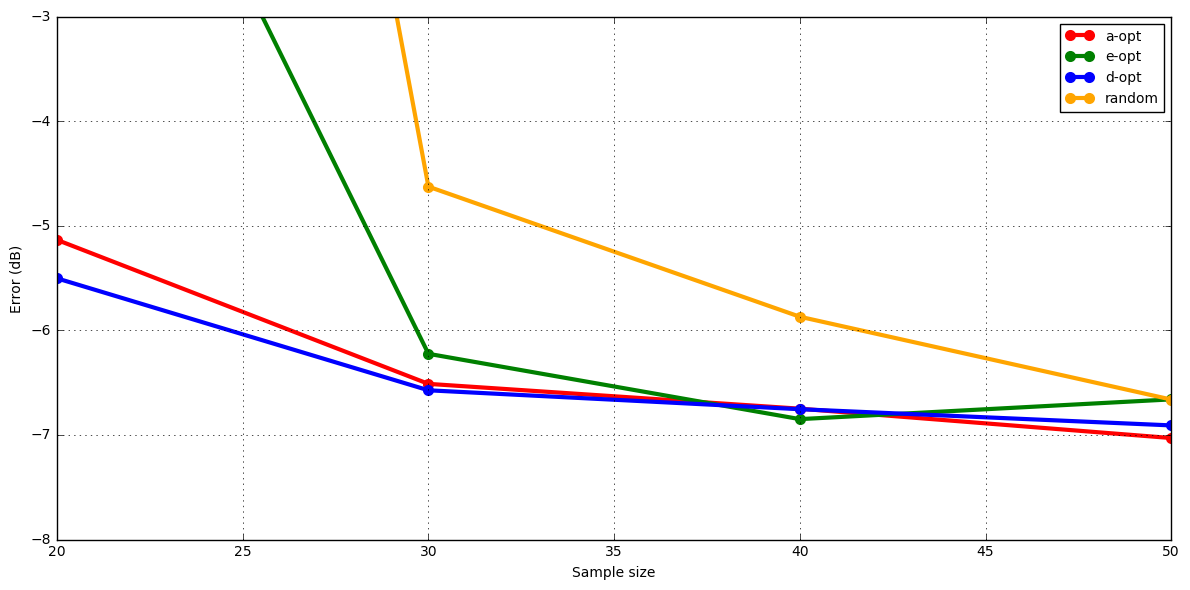

In [110]:
a_mse1 = []
e_mse1 = []
d_mse1 = []
r_mse1 = []
f = f_sample(20)
for i in range(len(m_vec)):
    a_mse1.append(nmse(f,a_set1[i],U,R,x))
    e_mse1.append(nmse(f,e_set1[i],U,R,x))
    d_mse1.append(nmse(f,d_set1[i],U,R,x)) 
    r_mse1.append(nmse(f,rand1[i],U,R,x))
plt.figure(figsize=(12,6))
plt.plot(m_vec,a_mse1, color = "red", label = "a-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,e_mse1, color = "green", label = "e-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,d_mse1, color = "blue", label = "d-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,r_mse1, color = "orange", label = "random",marker = ".", lw = 3, mew = 5)
plt.ylim([-8, -3])
plt.legend(loc='upper right',fontsize = 10)
plt.xlabel('Sample size')
plt.ylabel("Error (dB)")
plt.grid()
plt.tight_layout()
plt.savefig("fixed_b.png", format="PNG")
plt.show()

In [54]:
hubs = a_set1[-1]
vec = np.zeros(486)
vec[hubs] = 10

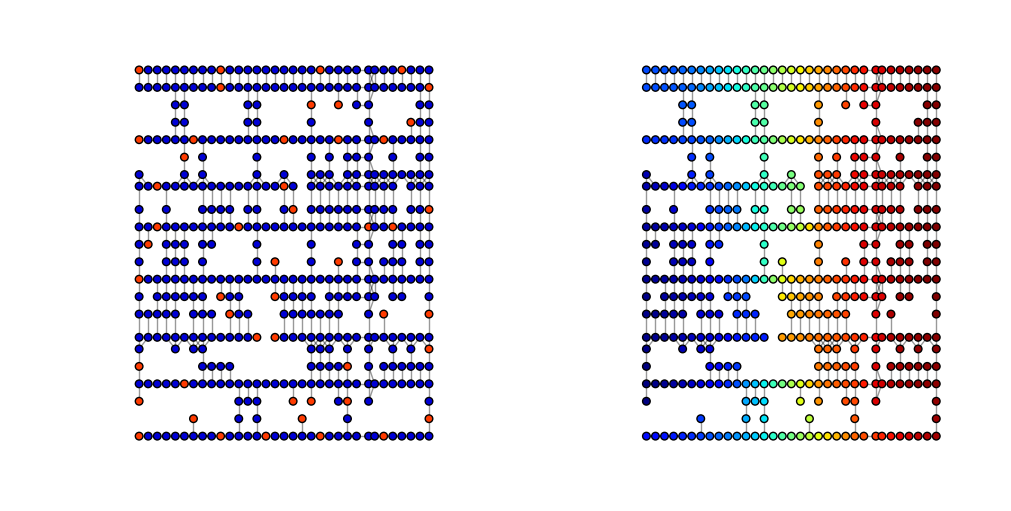

In [61]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=vec, node_shape='o', 
                            with_labels=True, node_size=30, cmap=plt.cm.jet,vmin= -1,vmax = 12)

plt.axis('off')
plt.subplot(1, 2, 2)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=e_sec, node_shape='o', 
                            with_labels=True, node_size=30, cmap=plt.cm.jet)

plt.axis('off')
plt.savefig("Samples.png", format="PNG")
plt.show()


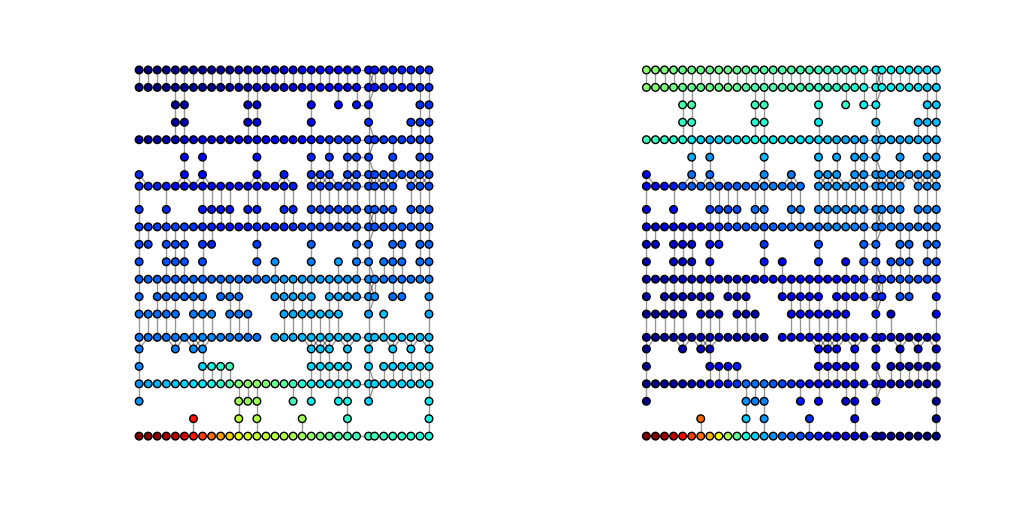

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=e_vec[2], node_shape='o', 
                            with_labels=True, node_size=30, cmap=plt.cm.jet)

plt.axis('off')
plt.subplot(1, 2, 2)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=e_vec[3], node_shape='o', 
                            with_labels=True, node_size=30, cmap=plt.cm.jet)

plt.axis('off')
plt.show()

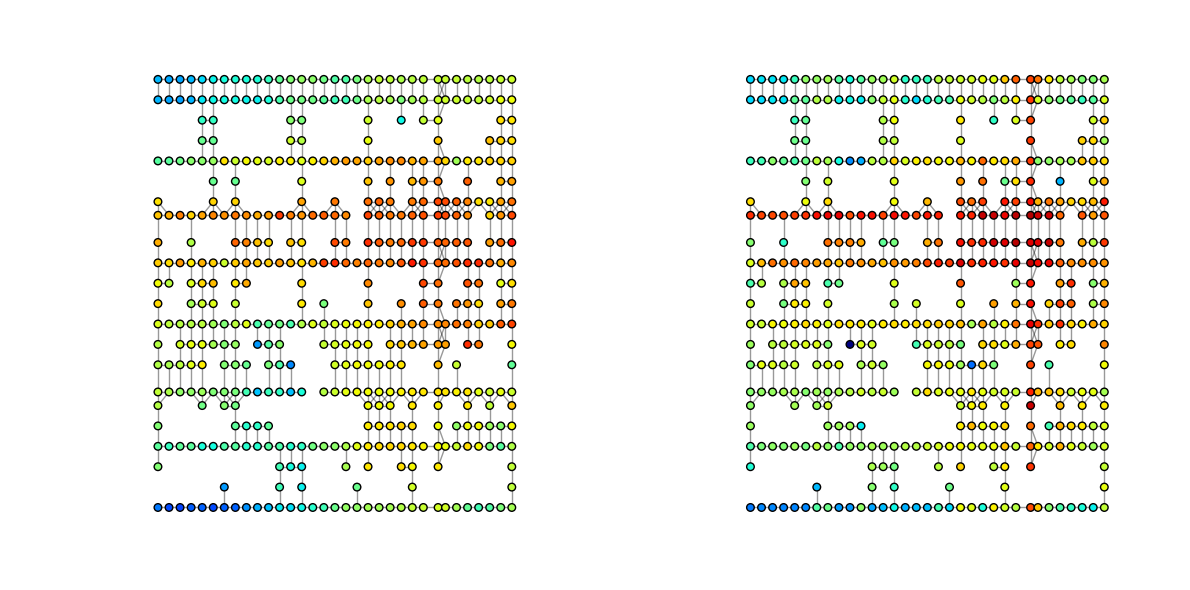

In [111]:
plt.figure(figsize=(12,6))
f = f_sample(20)
x_hat1 =reconstruct(f,a_set1[-1],U,R,x)
plt.subplot(1, 2, 1)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=np.asarray(x_hat1), with_labels=True,
                            node_shape='o', node_size=30, cmap=plt.cm.jet, vmin= -170,vmax = -20)

plt.axis('off')

plt.subplot(1, 2, 2)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=np.asarray(x), node_shape='o', 
                            with_labels=True, node_size=30, cmap=plt.cm.jet,  vmin= -170,vmax = -20)

plt.axis('off')
plt.tight_layout()
plt.savefig("Reconstructed_sample.png", format="PNG")
plt.show()


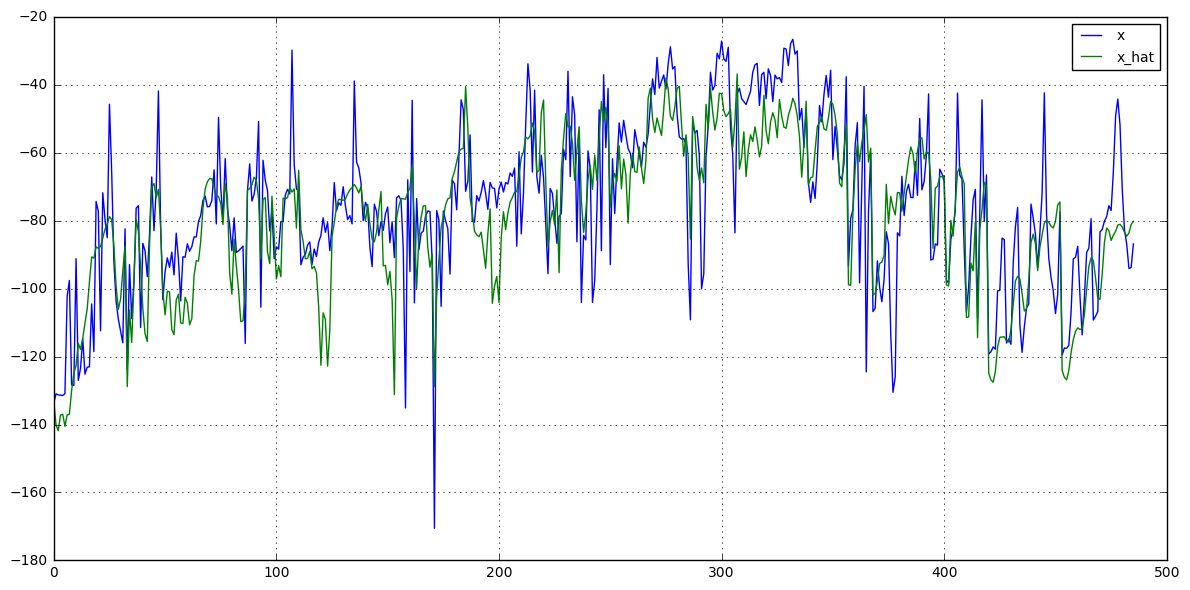

In [60]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(N),x,label = "x")
plt.plot(np.arange(N),x_hat1,label = "x_hat")
plt.legend(loc='upper right',fontsize = 10)
plt.savefig("original_vs_rec.png", format="PNG")
plt.grid()
plt.tight_layout()
plt.show()

### |f| = |s|

In [95]:
f_vec = [30,40,50,60]
a_set2 = []
#e_set2 = []
d_set2 = []
for i in range(len(f_vec)):
    f = f_sample(f_vec[i])
    s = f_vec[i] +10
    a = greedy(U,s,f,R,opt = "A")
    #e = greedy(U,s,f,R,opt = "E")
    d = greedy(U,s,f,R,opt = "D")

    a_set2.append(a)
    #e_set2.append(e)
    d_set2.append(d)
   #rand2.append(np.random.choice(range(N), f_vec[i]+10,replace= False))
    print("|f| = "+str(f_vec[i])+" |s| = "+ str(s)+" done")
allDone()

|f| = 30 |s| = 40 done
|f| = 40 |s| = 50 done
|f| = 50 |s| = 60 done
|f| = 60 |s| = 70 done


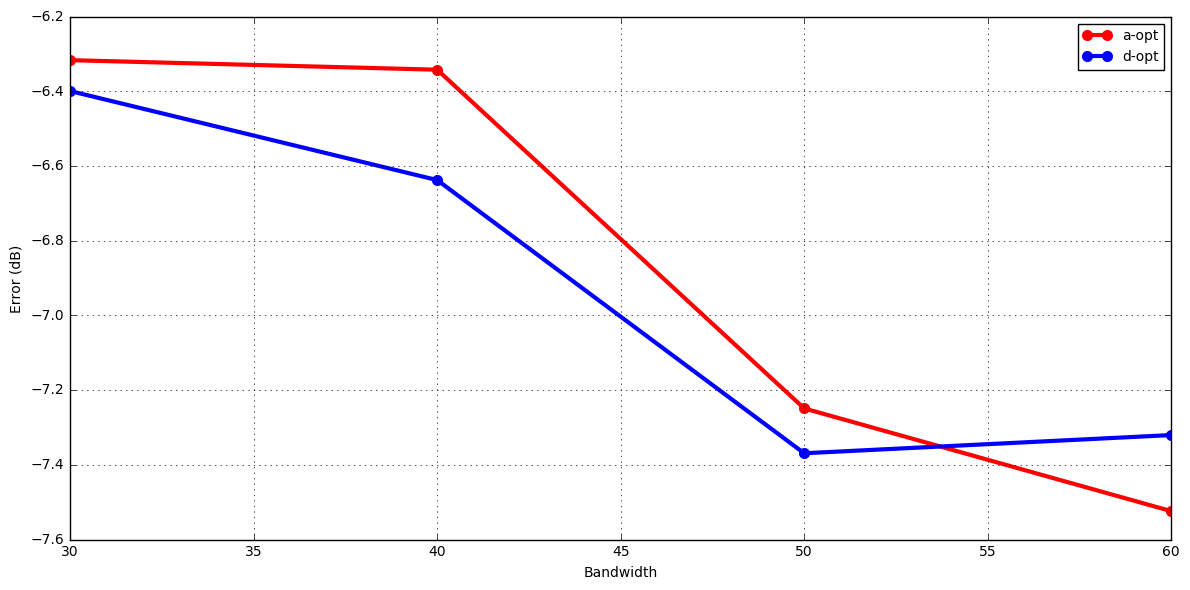

In [99]:
a_mse2 = []
#e_mse2 = []
d_mse2 = []
#r_mse2 = []
for i in range(len(f_vec)):
    f = f_sample(f_vec[i])
    a_mse2.append(nmse(f,a_set2[i],U,R,x))
    #e_mse2.append(nmse(f,e_set2[i],U,R,x))
    d_mse2.append(nmse(f,d_set2[i],U,R,x)) 
    #r_mse2.append(nmse(f,rand2[i],U,R,x))
plt.figure(figsize=(12,6))
plt.plot(f_vec,a_mse2, color = "red", label = "a-opt",marker = ".", lw = 3, mew = 5)
#plt.plot(f_vec,e_mse2, color = "green", label = "e-opt",marker = ".", lw = 3, mew = 5)
plt.plot(f_vec,d_mse2, color = "blue", label = "d-opt",marker = ".", lw = 3, mew = 5)
#plt.plot(f_vec,r_mse2, color = "orange", label = "random",marker = ".", lw = 3, mew = 5)
#plt.ylim([-10, 0])
plt.legend(loc='upper right',fontsize = 10)
plt.xlabel('Bandwidth')
plt.ylabel("Error (dB)")
plt.grid()
plt.tight_layout()
plt.savefig("bs.png", format="PNG")
plt.show()

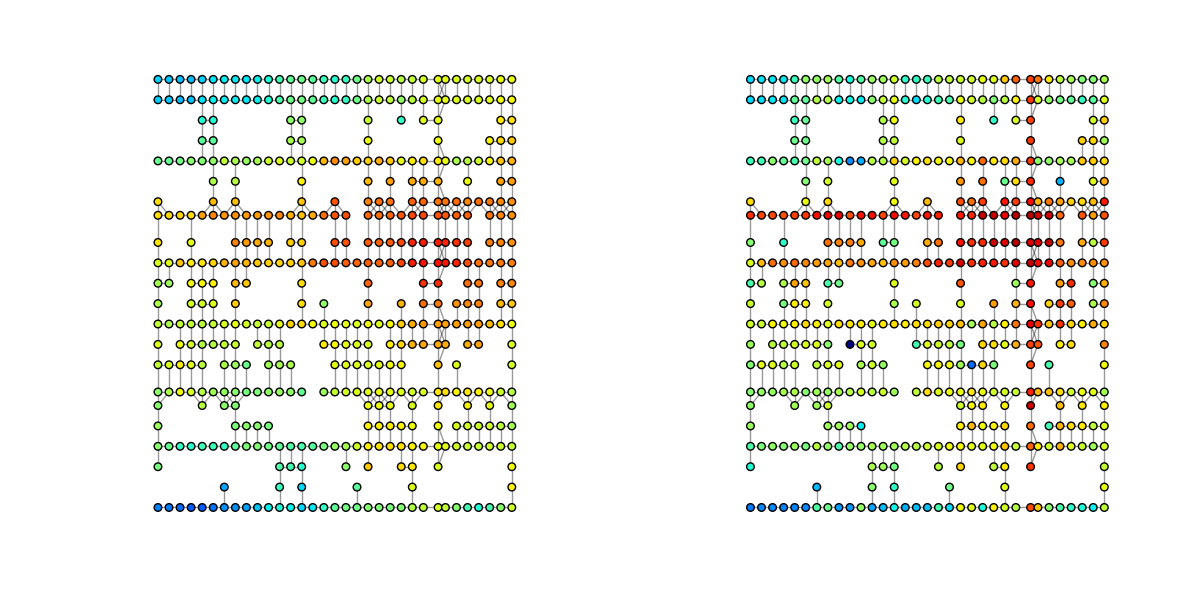

In [102]:
plt.figure(figsize=(12,6))
f = f_sample(f_vec[-1])
x_hat2 =reconstruct(f,a_set2[-1],U,R,x)
plt.subplot(1, 2, 1)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=np.asarray(x_hat1), with_labels=True,
                            node_shape='o', node_size=30, cmap=plt.cm.jet, vmin= -170,vmax = -20)

plt.axis('off')

plt.subplot(1, 2, 2)
ec = nx.draw_networkx_edges(G, loc, alpha=0.4)
nc = nx.draw_networkx_nodes(G, loc, node_color=np.asarray(x), node_shape='o', 
                            with_labels=True, node_size=30, cmap=plt.cm.jet,  vmin= -170,vmax = -20)

plt.axis('off')
plt.tight_layout()
plt.savefig("Reconstructed_sample.png", format="PNG")
plt.show()


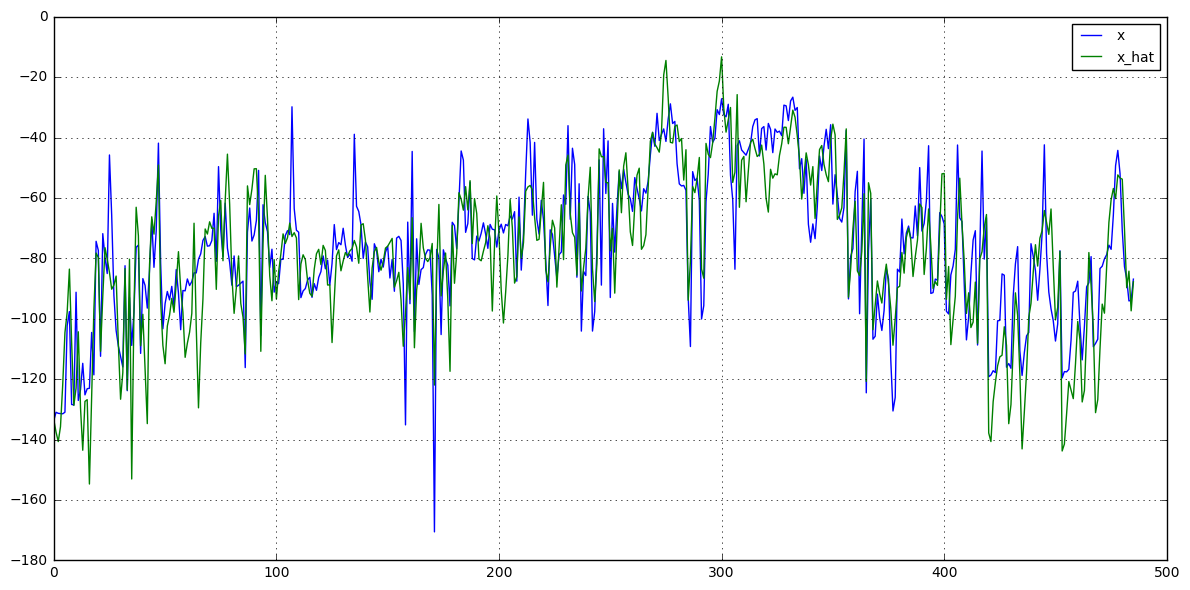

In [103]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(N),x,label = "x")
plt.plot(np.arange(N),x_hat2,label = "x_hat")
plt.legend(loc='upper right',fontsize = 10)
plt.savefig("original_vs_rec.png", format="PNG")
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
nmse(f_sample(30),a_set2[3],U,R,x)

-7.2938414278296424

### Convex Relaxation:

In [23]:
R_inv = inv(R)
f = f_sample(20)
U_f = np.zeros((N,len(f)))
col = 0
for j in  f:
    U_f[:,col] = list(np.asarray(U)[:,j])
    col = col+1
def f_d(d):
    N = len(U)
    D_s = np.diag(d)
    matrix = np.asmatrix(U_f).getH().dot(D_s).dot(R_inv).dot(U_f)
    eig_values,_ = np.linalg.eig(matrix)
    pseudo_determinent = np.product(eig_values[eig_values > 1e-12])
    res = np.log(pseudo_determinent)
    return(-res/10)
def f_a(d):
    N = len(U)
    D_s = np.diag(d)
    matrix = inv((np.asmatrix(U_f).getH().dot(D_s).dot(R_inv).dot(U_f)))
    res = np.trace(matrix)
    return(res/100000)
def f_e(d):
    N = len(U)
    D_s = np.diag(d)
    _1, s, _2 = np.linalg.svd(D_s.dot(U_f), full_matrices=True)
    return(-np.min(s)*100)

In [24]:
conv_res = []
for i in range(len(m_vec)):
    d = np.zeros(N)
    M = m_vec[i]
    d[np.random.choice(N,M,replace= False)] = 1
    cons = ({'type': 'eq', 'fun': lambda x:  np.transpose(np.ones(N)).dot(x) - M})
    bnds = []
    for i in range(N):
        bnds.append((0, 1))
    res = minimize(f_d, d,bounds=bnds, constraints =cons,
                   options={'maxiter': 500, 'disp': True})
    conv_res.append(res)
allDone()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.26374369049
            Iterations: 107
            Function evaluations: 52223
            Gradient evaluations: 107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.45649163674
            Iterations: 81
            Function evaluations: 39534
            Gradient evaluations: 81
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.89945315859
            Iterations: 102
            Function evaluations: 49777
            Gradient evaluations: 102
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.47997092227
            Iterations: 111
            Function evaluations: 54169
            Gradient evaluations: 111


In [25]:
ds = []
conv_nmse = []
f = f_sample(20)
for i in range(len(m_vec)):
    idx = np.argsort(conv_res[i].x)
    ds.append(idx[-m_vec[i]:])
    conv_nmse.append(nmse(f,ds[i],U,R,x))

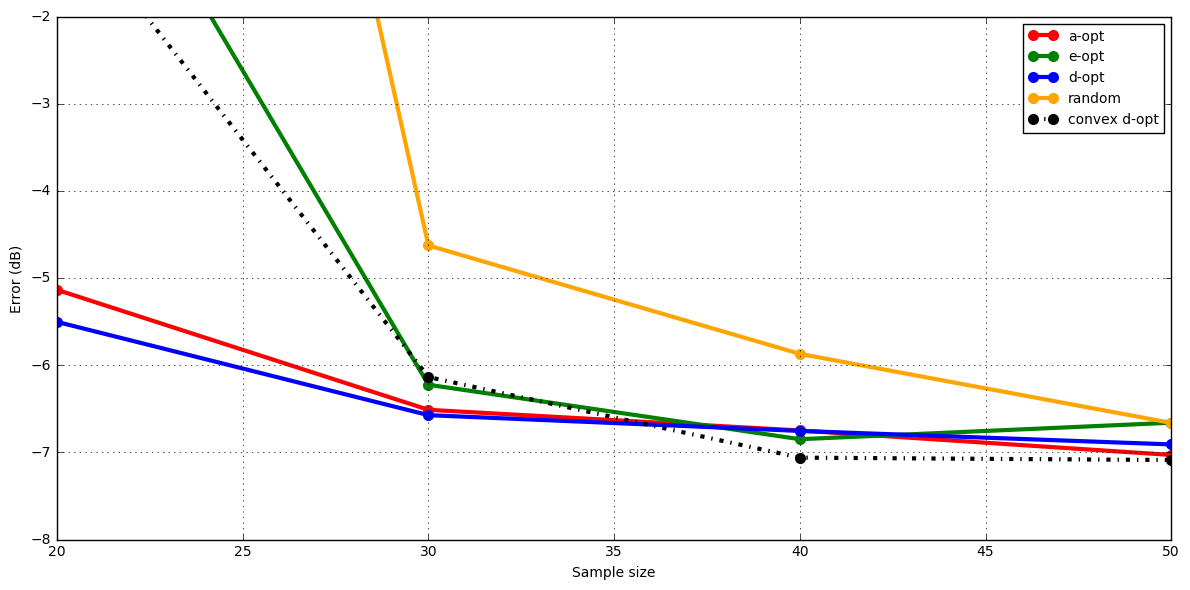

In [107]:
plt.figure(figsize=(12,6))
plt.plot(m_vec,a_mse1, color = "red", label = "a-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,e_mse1, color = "green", label = "e-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,d_mse1, color = "blue", label = "d-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,r_mse1, color = "orange", label = "random",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec, conv_nmse,color = "black", label = "convex d-opt",ls = "-.",marker = ".", lw = 3, mew = 5 )
plt.ylim([-8, -2])
plt.legend(loc='upper right',fontsize = 10)
plt.xlabel('Sample size')
plt.ylabel("Error (dB)")
plt.grid()
plt.tight_layout()
#plt.savefig("results.png", format="PNG")
plt.show()

In [27]:
conv_res_a = []
for i in range(len(m_vec)):
    d = np.zeros(N)
    M = m_vec[i]
    d[np.random.choice(N,M,replace= False)] = 1
    cons = ({'type': 'eq', 'fun': lambda x:  np.transpose(np.ones(N)).dot(x) - M})
    bnds = []
    for i in range(N):
        bnds.append((0, 1))
    res = minimize(f_a, d,bounds=bnds, constraints =cons,
                   options={'maxiter': 500, 'disp': True})
    conv_res_a.append(res)
allDone()

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5.81437982045e+14
            Iterations: 3
            Function evaluations: 976
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00254979051924
            Iterations: 270
            Function evaluations: 131772
            Gradient evaluations: 270
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00238511296659
            Iterations: 12
            Function evaluations: 5856
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00232005666354
            Iterations: 10
            Function evaluations: 4880
            Gradient evaluations: 10


In [28]:
dsa = []
conv_nmsea = []
f = f_sample(20)
for i in range(len(m_vec)):
    idx = np.argsort(conv_res_a[i].x)
    dsa.append(idx[-m_vec[i]:])
    conv_nmsea.append(nmse(f,dsa[i],U,R,x))

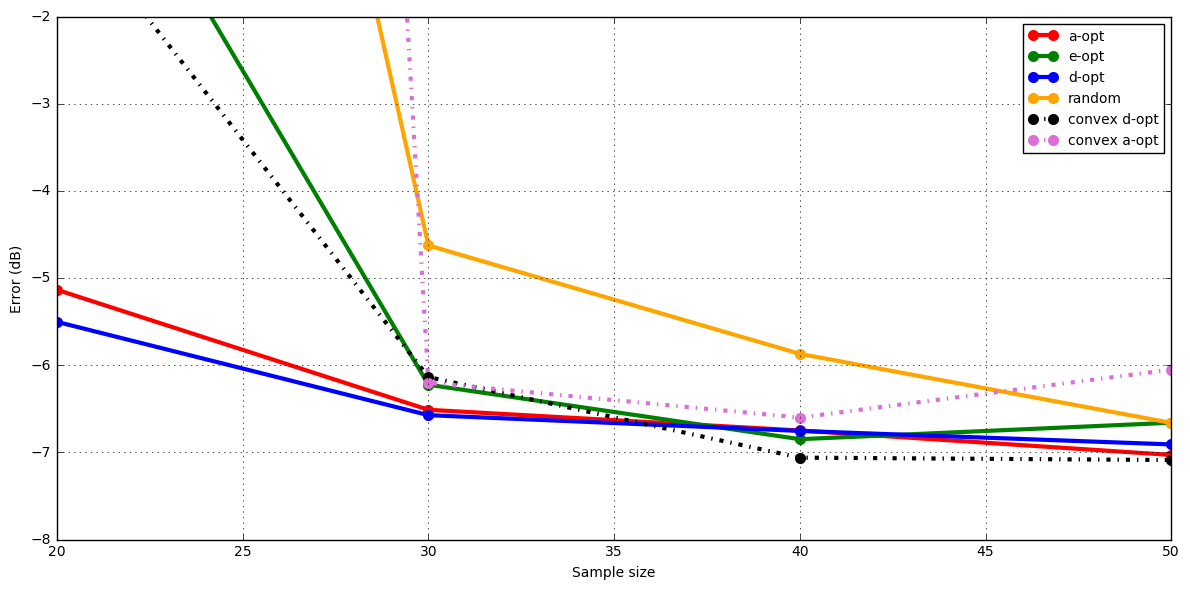

In [108]:
plt.figure(figsize=(12,6))
plt.plot(m_vec,a_mse1, color = "red", label = "a-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,e_mse1, color = "green", label = "e-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,d_mse1, color = "blue", label = "d-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,r_mse1, color = "orange", label = "random",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec, conv_nmse,color = "black", label = "convex d-opt",ls = "-.",marker = ".", lw = 3, mew = 5 )
plt.plot(m_vec, conv_nmsea,color = "orchid", label = "convex a-opt",ls = "-.",marker = ".", lw = 3, mew = 5 )

plt.ylim([-8, -2])
plt.legend(loc='upper right',fontsize = 10)
plt.xlabel('Sample size')
plt.ylabel("Error (dB)")
plt.grid()
plt.tight_layout()
plt.savefig("convex.png", format="PNG")
plt.show()

In [30]:
conv_res_e = []
for i in range(len(m_vec)):
    d = np.zeros(N)
    M = m_vec[i]
    d[np.random.choice(N,M,replace= False)] = 1
    cons = ({'type': 'eq', 'fun': lambda x:  np.transpose(np.ones(N)).dot(x) - M})
    bnds = []
    for i in range(N):
        bnds.append((0, 1))
    res = minimize(f_e, d,bounds=bnds, constraints =cons,
                   options={'maxiter': 500, 'disp': True})
    conv_res_e.append(res)
allDone()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.42888845295
            Iterations: 1
            Function evaluations: 488
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.21045540229
            Iterations: 1
            Function evaluations: 488
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.88932870579
            Iterations: 1
            Function evaluations: 488
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.02213973121
            Iterations: 1
            Function evaluations: 488
            Gradient evaluations: 1


In [31]:
dse = []
conv_nmsee = []
f = f_sample(20)
for i in range(len(m_vec)):
    idx = np.argsort(conv_res_e[i].x)
    dse.append(idx[-m_vec[i]:])
    conv_nmsee.append(nmse(f,dse[i],U,R,x))

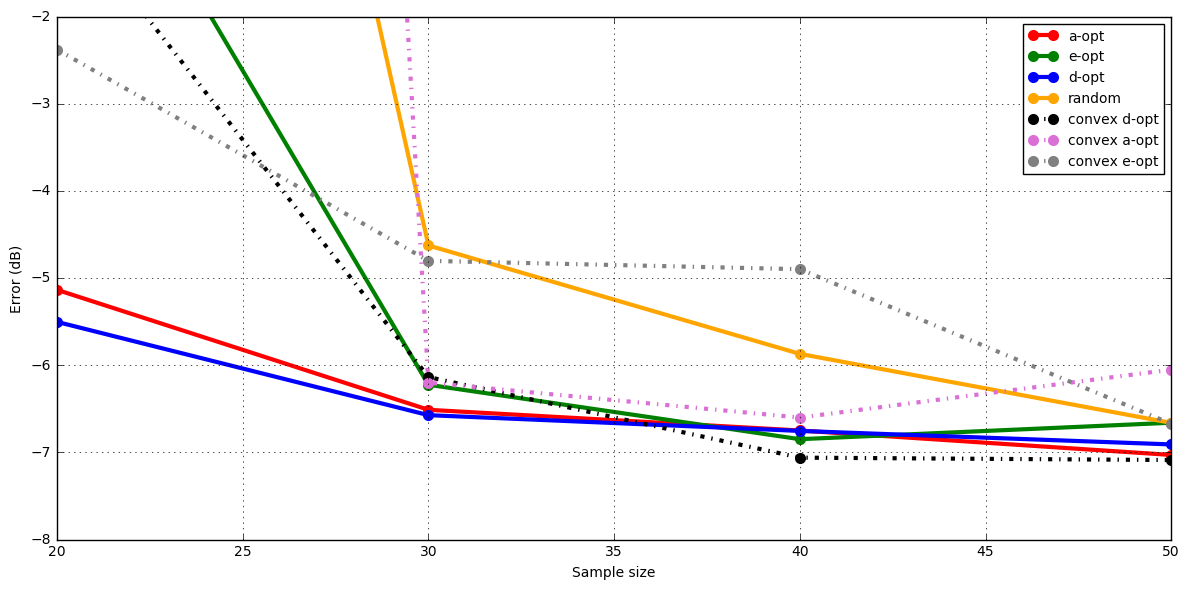

In [109]:
plt.figure(figsize=(12,6))
plt.plot(m_vec,a_mse1, color = "red", label = "a-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,e_mse1, color = "green", label = "e-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,d_mse1, color = "blue", label = "d-opt",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec,r_mse1, color = "orange", label = "random",marker = ".", lw = 3, mew = 5)
plt.plot(m_vec, conv_nmse,color = "black", label = "convex d-opt",ls = "-.",marker = ".", lw = 3, mew = 5 )
plt.plot(m_vec, conv_nmsea,color = "orchid", label = "convex a-opt",ls = "-.",marker = ".", lw = 3, mew = 5 )
plt.plot(m_vec, conv_nmsee,color = "grey", label = "convex e-opt",ls = "-.",marker = ".", lw = 3, mew = 5 )
plt.ylim([-8, -2])
plt.legend(loc='upper right',fontsize = 10)
plt.xlabel('Sample size')
plt.ylabel("Error (dB)")
plt.grid()
plt.tight_layout()
plt.savefig("convex.png", format="PNG")
plt.show()